In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
import os
import html
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from sklearn.preprocessing import LabelEncoder
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 23

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
dir_path = os.getcwd()
data_dir = os.path.join(dir_path, 'data')
nltk_data_dir= os.path.join(data_dir, 'nltk')

nltk.download('stopwords', download_dir=nltk_data_dir)
nltk.download('punkt', download_dir=nltk_data_dir)
nltk.download('vader_lexicon', download_dir=nltk_data_dir)

num_epochs = 20

##--Disabling the warnings for better notebook visibility
import warnings
warnings.simplefilter('ignore')

[nltk_data] Downloading package stopwords to C:\Users\Naty\Dropbox\UW
[nltk_data]     Shared\1 - ECE 657A\Project\data\nltk...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Naty\Dropbox\UW
[nltk_data]     Shared\1 - ECE 657A\Project\data\nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Naty\Dropbox\UW Shared\1 - ECE
[nltk_data]     657A\Project\data\nltk...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
rm_quote = lambda x: x.replace('"', '')
df_drugs_train = pd.read_csv(os.path.join(data_dir, 'drugsComTrain_raw.tsv'), sep='\t', index_col=0, converters={'review': rm_quote})
df_drugs_train = df_drugs_train.reset_index(drop=True)

df_drugs_test = pd.read_csv(os.path.join(data_dir, 'drugsComTest_raw.tsv'), sep='\t', index_col=0, converters={'review': rm_quote})
df_drugs_test = df_drugs_test.reset_index(drop=True)

## Preprocessing

In [6]:
#Contractions and numbers removal, based on https://stackoverflow.com/a/47091490
import re   
def decontracted(phrase):
    # specific
    phrase = re.sub("\d+", "", phrase) #Deletes all digits
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

unescaper = lambda x: decontracted(html.unescape(x))
df_drugs_train['review']=df_drugs_train['review'].apply(unescaper)
df_drugs_test['review']=df_drugs_test['review'].apply(unescaper)

lbs lost in . months using saxenda (dose between .-.) & following doctor's guidelines for eating.  Did not exercise during the months. I was losing except for physical therapy x a week for back.  I am at a good weight for me ('", , age ) and have been maintaining within -lbs for about  mos. now but still using saxenda.  Have not been super strict with diet but not going crazy either.  Added light weight training and walking on treadmill - days a week right before Christmas.  If I overeat a day or  I go back to watching and the weight comes right back down.  Thankfully husband's insurance covers drug because mine does not.  Feel great, cholesterol & blood pressure good again, back is better, and clothes fit.


In [7]:
#Rating labeler
def rating_labeler(val):
    if val>4:
        if val<7:
            lbl="Neutral"
        else:
            lbl="Positive"
    else:
        lbl="Negative"
    return lbl

df_drugs_train_labeled= df_drugs_train.copy()
df_drugs_train_labeled['rating_label'] = df_drugs_train_labeled['rating'].apply(lambda row: rating_labeler(row))

df_drugs_test_labeled= df_drugs_test.copy()
df_drugs_test_labeled['rating_label'] = df_drugs_test_labeled['rating'].apply(lambda row: rating_labeler(row))

,drugName,condition,review,rating,date,usefulCount,rating_label
0,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9.0,"May 20, 2012",27,Positive
1,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8.0,"April 27, 2010",192,Positive
2,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5.0,"December 14, 2009",17,Neutral
3,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8.0,"November 3, 2015",10,Positive
4,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9.0,"November 27, 2016",37,Positive
5,Cialis,Benign Prostatic Hyperplasia,nd day on mg started to work with rock hard er...,2.0,"November 28, 2015",43,Negative
6,Levonorgestrel,Emergency Contraception,"He pulled out, but he cummed a bit in me. I to...",1.0,"March 7, 2017",5,Negative
7,Aripiprazole,Bipolar Disorde,Abilify changed my life. There is hope. I was ...,10.0,"March 14, 2015",32,Positive
8,Keppra,Epilepsy,I Ve had nothing but problems with the Keppe...,1.0,"August 9, 2016",11,Negative
9,Ethinyl estradiol / levonorgestrel,Birth Control,I had been on the pill for many years. When my...,8.0,"December 8, 2016",1,Positive


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# CNN without GloVe

In [19]:
#Train test without tokenization
# my_df = df_drugs_Xtrain_labeled.copy()
# my_df=my_df[my_df['rating_label']!= 'Neutral']
# my_df['totalwords'] = my_df['review'].str.split().str.len()
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

stp_words=stopwords.words('english')
def stopword_removal(text, words):
    """
    :param title: string you want to split.
    :param words: list of words you are looking to match.
    :param randoms: list of random words to replace with words.
    :return: new title
    """
    text=text.lower()
    text=' '.join(['' if word in words else word 
                    for word in text.split()])
    text=re.sub(' +', ' ', text)
    text=text.lstrip()
    return text

stp_word = lambda x: stopword_removal(x, stp_words)

df_drugs_train_labeled['review'] = df_drugs_train_labeled['review'].str.lower()
df_drugs_train_labeled['review'] = df_drugs_train_labeled['review'].apply(stp_word)
df_drugs_train_labeled['review'] = df_drugs_train_labeled['review'].str.strip()

df_drugs_test_labeled['review'] = df_drugs_test_labeled['review'].str.lower()
df_drugs_test_labeled['review'] = df_drugs_test_labeled['review'].apply(stp_word)
df_drugs_test_labeled['review'] = df_drugs_test_labeled['review'].str.strip()


X_train = df_drugs_train_labeled['review']
X_test = df_drugs_test_labeled['review']

y_train = df_drugs_train_labeled['rating_label']
y_test = df_drugs_test_labeled['rating_label']

# encode class values as integers
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
y_train_dummy = np_utils.to_categorical(y_train_enc)
y_test_dummy = np_utils.to_categorical(y_test_enc)

#Train test split
X_train, X_val, y_train_dummy, y_val_dummy = train_test_split(X_train, y_train_dummy, test_size=0.2,
                                                  random_state=1, stratify = df_drugs_train_labeled['rating_label'])


Using TensorFlow backend.


In [20]:
#Tokenization and sequencing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#Tokenization
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(X_train)

#Sequencing
sequences = tokenizer.texts_to_sequences(X_train)

length = []
for x in X_train:
    length.append(len(x.split()))
mxlen=max(length)
#----------------------
X_train_seq = pad_sequences(sequences, maxlen=mxlen)
#----------------------
sequences_val = tokenizer.texts_to_sequences(X_val)
X_val_seq = pad_sequences(sequences_val, maxlen=mxlen)
#----------------------
sequences_test = tokenizer.texts_to_sequences(X_test)
X_test_seq = pad_sequences(sequences_test, maxlen=mxlen)

In [39]:
#Create the model
from keras.layers import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D,CuDNNLSTM
#----------------------
from keras.layers import Input, Activation, LSTM
from keras.models import Model

drugs_input = Input(shape=(mxlen,), dtype='int32')

drugs_encoder = Embedding(100000, 200, input_length=mxlen)(drugs_input)
drugs_lstm=(CuDNNLSTM(200))(drugs_encoder)
dropOut = (Dropout(0.5))(drugs_lstm)
output = (Dense(3, activation='sigmoid'))(dropOut)
model = Model(inputs=[drugs_input], outputs=[output])
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['categorical_crossentropy', 'accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 1000, 200)         20000000  
_________________________________________________________________
cu_dnnlstm_9 (CuDNNLSTM)     (None, 200)               321600    
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 603       
Total params: 20,322,203
Trainable params: 20,322,203
Non-trainable params: 0
_________________________________________________________________


In [40]:
from keras.callbacks import ModelCheckpoint
filepath="LSTM_best_weights_SW_noemb.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model.fit(X_train_seq, y_train_dummy, batch_size=32, epochs=num_epochs,
                     validation_data=(X_val_seq, y_val_dummy), callbacks = [checkpoint])


Train on 129037 samples, validate on 32260 samples
Epoch 1/20
129037/129037 [==============================] - 365s 3ms/step - loss: 0.5900 - categorical_crossentropy: 0.5900 - acc: 0.7776 - val_loss: 0.5212 - val_categorical_crossentropy: 0.5212 - val_acc: 0.8063

Epoch 00001: val_acc improved from -inf to 0.80626, saving model to LSTM_best_weights_SW_noemb.01-0.8063.hdf5
Epoch 2/20
129037/129037 [==============================] - 363s 3ms/step - loss: 0.4526 - categorical_crossentropy: 0.4526 - acc: 0.8300 - val_loss: 0.4941 - val_categorical_crossentropy: 0.4941 - val_acc: 0.8155

Epoch 00002: val_acc improved from 0.80626 to 0.81550, saving model to LSTM_best_weights_SW_noemb.02-0.8155.hdf5
Epoch 3/20
129037/129037 [==============================] - 367s 3ms/step - loss: 0.3573 - categorical_crossentropy: 0.3573 - acc: 0.8669 - val_loss: 0.5007 - val_categorical_crossentropy: 0.5007 - val_acc: 0.8265

Epoch 00003: val_acc improved from 0.81550 to 0.82650, saving model to LSTM_best_

In [41]:
#Save a copy of the model
model_no_emb = model

In [ ]:
#Print the accuracy and loss
np.set_printoptions(precision=4, suppress=True)
eval_results = model_no_emb.evaluate(X_test_seq, y_test_dummy) 
print("\nLoss, accuracy on test data: ")
print("%0.4f %0.2f%%" % (eval_results[0], \
  eval_results[2]*100))

In [37]:
# NN plotting function. Works by calling the function plot_history(model) where model is the cnn model
# Taken from https://realpython.com/python-keras-text-classification/
import matplotlib.pyplot as plt
# plt.style.use('ggplot')

def plot_history(mod):
    acc = mod.history.history['acc']
    val_acc = mod.history.history['val_acc']
    loss = mod.history.history['loss']
    val_loss = mod.history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(18, 10))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc = 'best')
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training Loss')
    plt.plot(x, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc = 'best')

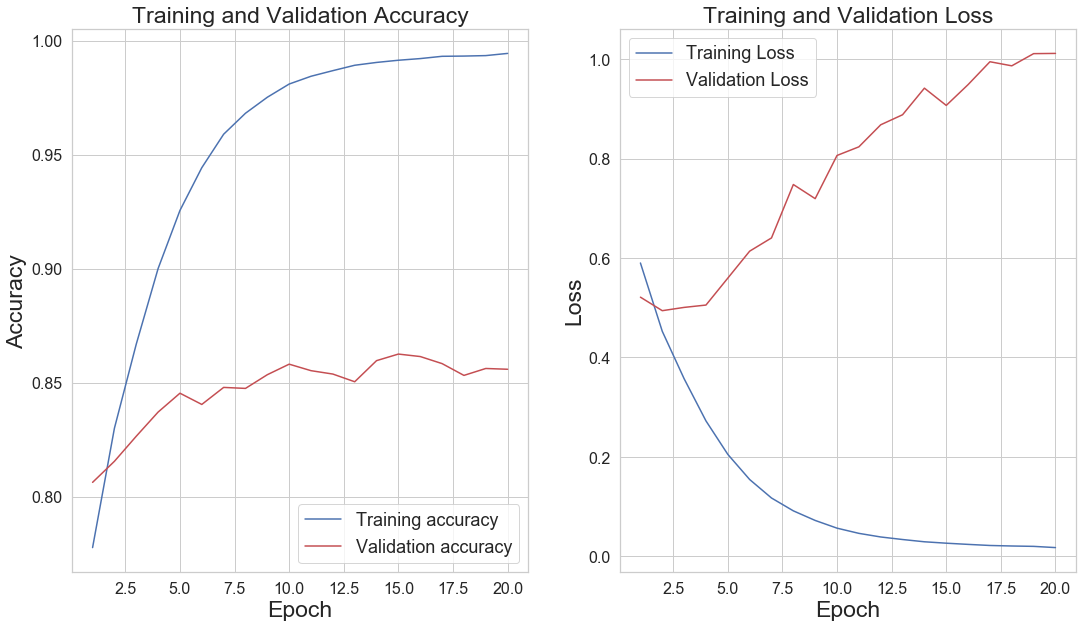

In [46]:
#Plot the accuracy and loss
plot_history(model_no_emb)

In [31]:
#Pretty print confusion matrix, based on the code created by Shaypal5:
# https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    #Created by:
    # Shaypal5
    # https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [51]:
#Create the classification report:
from sklearn.metrics import classification_report
from sklearn import metrics
y_predict = model.predict(X_test_seq)
y_pred = np.zeros_like(y_predict)
y_pred[np.arange(len(y_predict)), y_predict.argmax(1)] = 1

r,_ = y_pred.shape

y_p = np.zeros(r)
y_t = np.zeros(r)

for i in range(r):
    y_p[i] = 1*y_pred[i][0] + 2*y_pred[i][1] + 3*y_pred[i][2]
    y_t[i] = 1*y_test_dummy[i][0] + 2*y_test_dummy[i][1] + 3*y_test_dummy[i][2]


print(classification_report(y_t,y_p))
print(metrics.accuracy_score(y_t,y_p))

              precision    recall  f1-score   support

         1.0       0.82      0.80      0.81     13497
         2.0       0.57      0.57      0.57      4829
         3.0       0.91      0.92      0.91     35440

   micro avg       0.86      0.86      0.86     53766
   macro avg       0.77      0.76      0.76     53766
weighted avg       0.86      0.86      0.86     53766

0.8560428523602277


              precision    recall  f1-score   support

         1.0       0.80      0.79      0.79     13497
         2.0       0.55      0.48      0.51      4829
         3.0       0.90      0.92      0.91     35440

   micro avg       0.85      0.85      0.85     53766
   macro avg       0.75      0.73      0.74     53766
weighted avg       0.84      0.85      0.84     53766



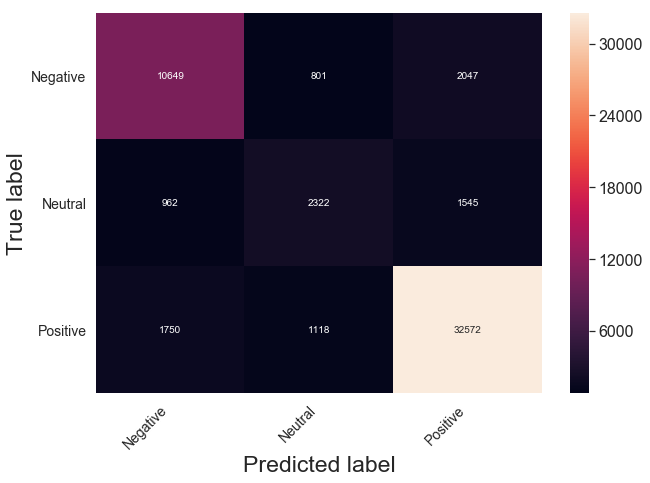

In [44]:
print(classification_report(y_t,y_p))
fig = print_confusion_matrix(metrics.confusion_matrix(y_t, y_p),['Negative', 'Neutral', 'Positive'])

# With Non-trainable Embedding

In [56]:
#Now using embedding:

EMBEDDING_DIM=100
word_index = tokenizer.word_index

In [57]:
#Compute an index mapping
embeddings_index = {}
f = open(os.path.join(data_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [58]:
#Creating the embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [68]:
#Creating the Artificial Neural Network model
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
#----------------------
from keras.layers import Input, Dense, concatenate, Activation, CuDNNLSTM
from keras.models import Model

drugs_input = Input(shape=(mxlen,), dtype='int32')

drugs_encoder = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=mxlen, trainable=False)(drugs_input)
drugs_lstm=(CuDNNLSTM(200))(drugs_encoder)
dropOut = (Dropout(0.5))(drugs_lstm)
output = (Dense(3, activation='sigmoid'))(dropOut)
model = Model(inputs=[drugs_input], outputs=[output])
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['categorical_crossentropy', 'accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 1000, 100)         4520000   
_________________________________________________________________
cu_dnnlstm_12 (CuDNNLSTM)    (None, 200)               241600    
_________________________________________________________________
dropout_11 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 603       
Total params: 4,762,203
Trainable params: 242,203
Non-trainable params: 4,520,000
_________________________________________________________________


In [60]:
#Train the model
from keras.callbacks import ModelCheckpoint
filepath="LSTM_best_weights_SW_NoTrainEmb.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model.fit(X_train_seq, y_train_dummy, batch_size=32, epochs=num_epochs,
                     validation_data=(X_val_seq, y_val_dummy), callbacks = [checkpoint])

Train on 129037 samples, validate on 32260 samples
Epoch 1/20
129037/129037 [==============================] - 242s 2ms/step - loss: 0.6819 - categorical_crossentropy: 0.6819 - acc: 0.7318 - val_loss: 0.6791 - val_categorical_crossentropy: 0.6791 - val_acc: 0.7402

Epoch 00001: val_acc improved from -inf to 0.74024, saving model to LSTM_best_weights_SW_NoTrainEmb.01-0.7402.hdf5
Epoch 2/20
129037/129037 [==============================] - 241s 2ms/step - loss: 0.6025 - categorical_crossentropy: 0.6025 - acc: 0.7678 - val_loss: 0.5744 - val_categorical_crossentropy: 0.5744 - val_acc: 0.7803

Epoch 00002: val_acc improved from 0.74024 to 0.78029, saving model to LSTM_best_weights_SW_NoTrainEmb.02-0.7803.hdf5
Epoch 3/20
129037/129037 [==============================] - 245s 2ms/step - loss: 0.5554 - categorical_crossentropy: 0.5554 - acc: 0.7880 - val_loss: 0.5524 - val_categorical_crossentropy: 0.5524 - val_acc: 0.7884

Epoch 00003: val_acc improved from 0.78029 to 0.78838, saving model to 

In [61]:
model_no_train_emb = model

In [62]:
#Print accuracy and loss on test data
np.set_printoptions(precision=4, suppress=True)
eval_results = model.evaluate(X_test_seq, y_test_dummy) 
print("\nLoss, accuracy on test data: ")
print("%0.4f %0.2f%%" % (eval_results[0], \
  eval_results[2]*100))

53766/53766 [==============================] - 36s 673us/step

Loss, accuracy on test data: 
0.6111 83.50%


              precision    recall  f1-score   support

         1.0       0.76      0.82      0.79     13497
         2.0       0.46      0.49      0.47      4829
         3.0       0.92      0.89      0.90     35440

   micro avg       0.84      0.84      0.84     53766
   macro avg       0.71      0.73      0.72     53766
weighted avg       0.84      0.84      0.84     53766



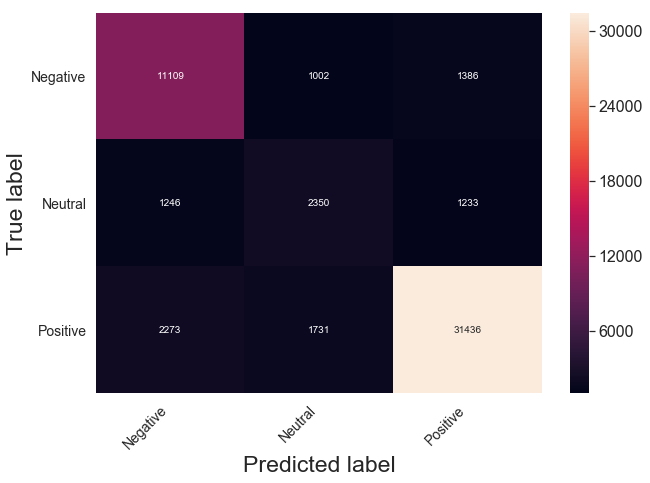

In [63]:
#Print the classification report and confusion matrix
from sklearn.metrics import classification_report
y_predict = model.predict(X_test_seq)
y_pred=[]
y_pred = np.zeros_like(y_predict)
y_pred[np.arange(len(y_predict)), y_predict.argmax(1)] = 1

r,_ = y_pred.shape

y_p = np.zeros(r)
y_t = np.zeros(r)

for i in range(r):
    y_p[i] = 1*y_pred[i][0] + 2*y_pred[i][1] + 3*y_pred[i][2]
    y_t[i] = 1*y_test_dummy[i][0] + 2*y_test_dummy[i][1] + 3*y_test_dummy[i][2]

print(classification_report(y_t,y_p))
fig = print_confusion_matrix(metrics.confusion_matrix(y_t,y_p),['Negative', 'Neutral', 'Positive'])

In [64]:
#Print the accuracy
print(metrics.accuracy_score(y_t,y_p))

0.8350072536547261


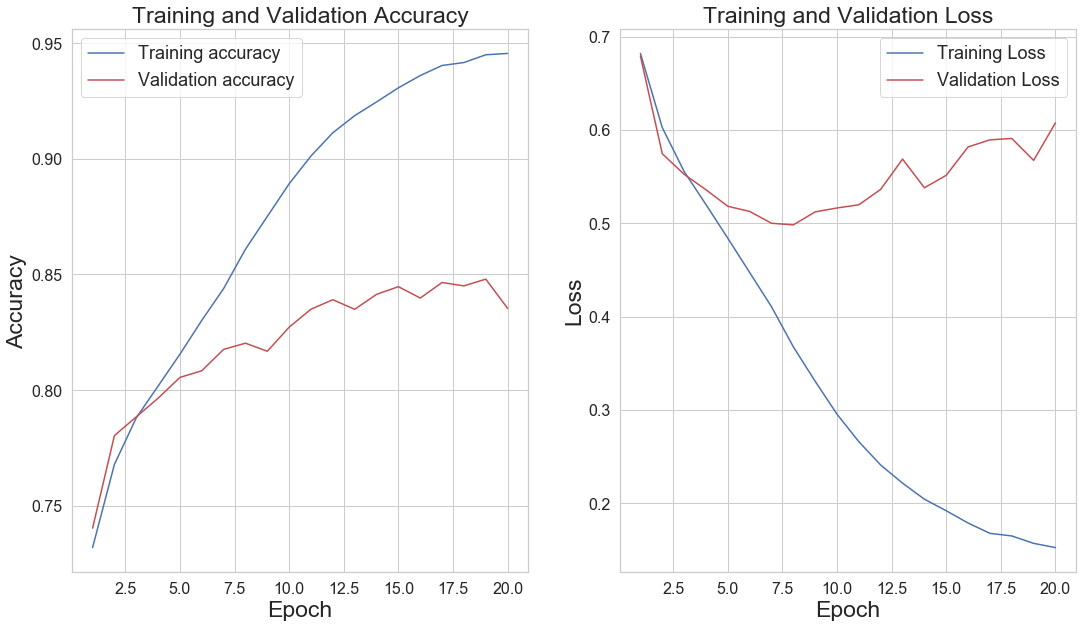

In [65]:
#Plot the accuracy and loss
plot_history(model_no_train_emb)

# With Trainable Embedding

In [21]:
#Recreate the embedding
EMBEDDING_DIM=100
word_index = tokenizer.word_index

In [22]:
#Compute the index mapping
embeddings_index = {}
f = open(os.path.join(data_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [23]:
#Create the specific embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [26]:
# Create the model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, CuDNNLSTM
#----------------------
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model

drugs_input = Input(shape=(mxlen,), dtype='int32')

drugs_encoder = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=mxlen, trainable=True)(drugs_input)
drugs_lstm=(CuDNNLSTM(200))(drugs_encoder)
dropOut = (Dropout(0.5))(drugs_lstm)
output = (Dense(3, activation='sigmoid'))(dropOut)
model = Model(inputs=[drugs_input], outputs=[output])
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['categorical_crossentropy', 'accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1000, 100)         4520000   
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 200)               241600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 603       
Total params: 4,762,203
Trainable params: 4,762,203
Non-trainable params: 0
_________________________________________________________________


In [27]:
#Train the model
from keras.callbacks import ModelCheckpoint
filepath="LSTM_best_weights_SW_TrainEmb.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model.fit(X_train_seq, y_train_dummy, batch_size=32, epochs=num_epochs,
                     validation_data=(X_val_seq, y_val_dummy), callbacks = [checkpoint])

Instructions for updating:
Use tf.cast instead.
Train on 129037 samples, validate on 32260 samples
Epoch 1/20
129037/129037 [==============================] - 502s 4ms/step - loss: 0.5948 - categorical_crossentropy: 0.5948 - acc: 0.7757 - val_loss: 0.5299 - val_categorical_crossentropy: 0.5299 - val_acc: 0.8004

Epoch 00001: val_acc improved from -inf to 0.80043, saving model to LSTM_best_weights_SW_TrainEmb.01-0.8004.hdf5
Epoch 2/20
129037/129037 [==============================] - 263s 2ms/step - loss: 0.4664 - categorical_crossentropy: 0.4664 - acc: 0.8246 - val_loss: 0.4941 - val_categorical_crossentropy: 0.4941 - val_acc: 0.8136

Epoch 00002: val_acc improved from 0.80043 to 0.81361, saving model to LSTM_best_weights_SW_TrainEmb.02-0.8136.hdf5
Epoch 3/20
129037/129037 [==============================] - 263s 2ms/step - loss: 0.3737 - categorical_crossentropy: 0.3737 - acc: 0.8592 - val_loss: 0.4765 - val_categorical_crossentropy: 0.4765 - val_acc: 0.8265

Epoch 00003: val_acc improv

In [28]:
#Save a copy of the model
model_train_emb = model

In [29]:
#Print the accuracy and loss on the test data
np.set_printoptions(precision=4, suppress=True)
eval_results = model.evaluate(X_test_seq, y_test_dummy) 
print("\nLoss, accuracy on test data: ")
print("%0.4f %0.2f%%" % (eval_results[0], \
  eval_results[2]*100))

53766/53766 [==============================] - 35s 660us/step

Loss, accuracy on test data: 
1.0063 85.85%


              precision    recall  f1-score   support

         1.0       0.80      0.82      0.81     13497
         2.0       0.58      0.57      0.57      4829
         3.0       0.92      0.91      0.92     35440

   micro avg       0.86      0.86      0.86     53766
   macro avg       0.77      0.77      0.77     53766
weighted avg       0.86      0.86      0.86     53766



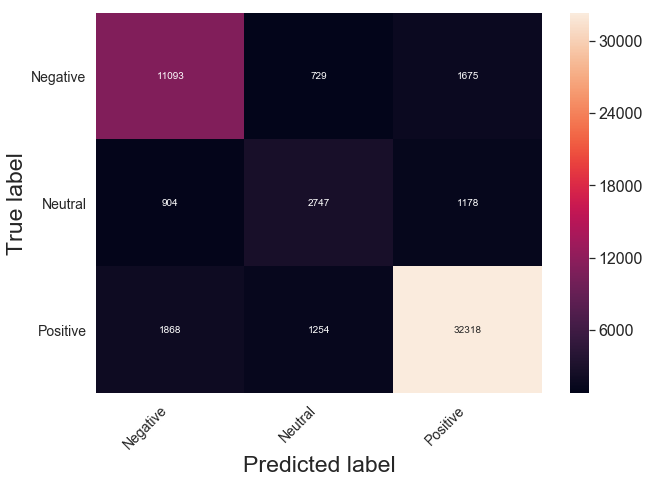

In [34]:
#Print the classification report and confusion matrix
from sklearn.metrics import classification_report
from sklearn import metrics
y_predict = model.predict(X_test_seq)
y_pred = np.zeros_like(y_predict)
y_pred[np.arange(len(y_predict)), y_predict.argmax(1)] = 1

r,_ = y_pred.shape

y_p = np.zeros(r)
y_t = np.zeros(r)

for i in range(r):
    y_p[i] = 1*y_pred[i][0] + 2*y_pred[i][1] + 3*y_pred[i][2]
    y_t[i] = 1*y_test_dummy[i][0] + 2*y_test_dummy[i][1] + 3*y_test_dummy[i][2]

print(classification_report(y_t,y_p))
# print('Confusion Matrix:')
# print(metrics.confusion_matrix(y_test,y_pred))
fig = print_confusion_matrix(metrics.confusion_matrix(y_t, y_p),['Negative', 'Neutral', 'Positive'])

In [35]:
#Print the test accuracy
print(metrics.accuracy_score(y_t,y_p))

0.8584979354982702


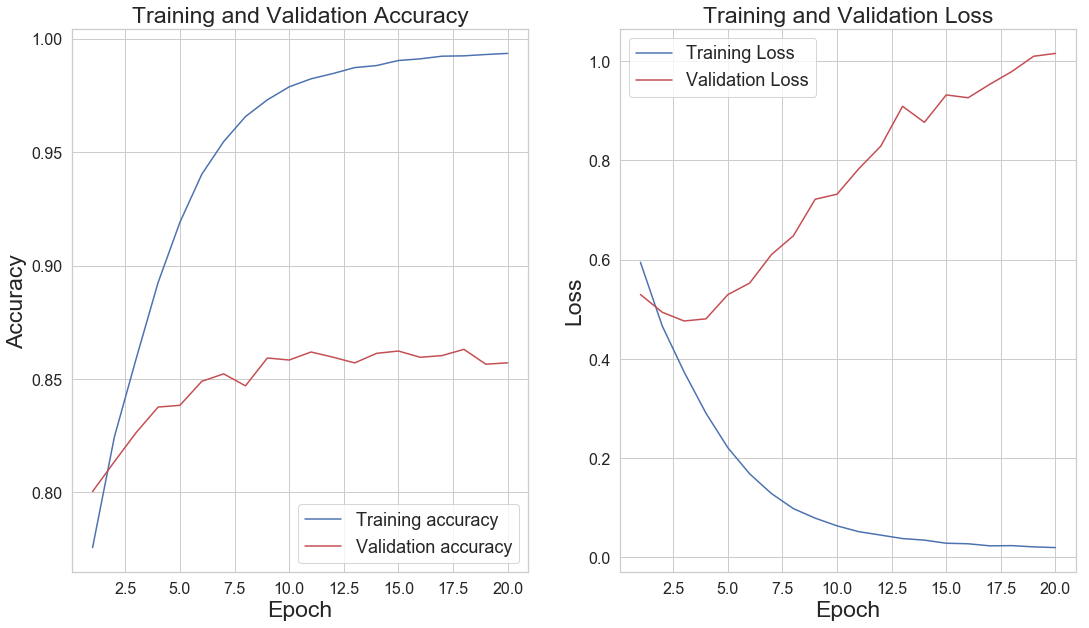

In [38]:
#Plot the accuracy and loss
plot_history(model_train_emb)

In [ ]:
#Compare the three models
def plot_multi_history(mod1, mod2, mod3):
    acc=[]
    val_acc=[]
    acc.append(mod1.history.history['acc'])
    val_acc.append(mod1.history.history['val_acc'])
    
    acc.append(mod2.history.history['acc'])
    val_acc.append(mod2.history.history['val_acc'])
    
    acc.append(mod3.history.history['acc'])
    val_acc.append(mod3.history.history['val_acc'])
    

    x = range(1, len(acc[0]) + 1)
    models=['No GloVe', 'GloVe with Training', 'GloVe w/o Training']
    alpha_vals=[1, 0.7, 0.6]
    lw_vals=[3,2,1]
    
    plt.figure(figsize=(18, 10))
    for mod_acc, mod, alph, line_w in zip(acc, models, alpha_vals, lw_vals):
        plt.plot(x, mod_acc, color='r', alpha=alph, lw=line_w, label='Train Acc for ' + mod)
    for mod_val_acc, mod, alph, line_w in zip(val_acc, models, alpha_vals, lw_vals):
        plt.plot(x, mod_val_acc, color='b', alpha=alph, lw=line_w, label='Val Acc for ' + mod)
    plt.title('Training and validation accuracy')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    
plot_multi_history(model_no_emb, model_train_emb, model_no_train_emb)